<h1 style="text-align: center; font-size: 50px;">DreamBooth on Stable Diffusion 2.1</h1>

DreamBooth is a powerful technique for personalizing latent diffusion models, such as Stable Diffusion, allowing the model to be fine-tuned to generate specific images based on a limited set of data.

# Notebook Overview
- Imports
- Configurations
- Verify Assets
- Download model local
- Load the Model
- DreamBooth Training
- Inference Local Model
- Custom Image Quality Metrics
- Model Service

## Imports

This command installs the "diffusers" library directly from the Hugging Face GitHub repository.The diffusers library is used to work with latent diffusion models, such as Stable Diffusion, and provides tools for image generation, fine-tuning, and other functionalities.


In [1]:
%pip install -r ../requirements.txt --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 24.1 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


### Configuration and Secrets Loading
In this section, we load configuration parameters and API keys from separate YAML files. This separation helps maintain security by keeping sensitive information (API keys) separate from configuration settings.

- **config.yaml**: Contains non-sensitive configuration parameters like model sources and URLs
- **secrets.yaml**: Contains sensitive API keys for services like HuggingFace

> ⚠️ **Warning**: If your GPU uses an older architecture (e.g., **pre-Pascal**, such as **Maxwell or earlier**), please uncomment the following line to avoid CUDA timeout issues:
```python
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
```


In [ ]:
import os
import sys

#os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from src.utils import (
    load_config_and_secrets,
    configure_proxy,
    get_project_root,
    get_config_dir,
    get_output_dir,
    get_default_model_path,
    get_model_cache_dir,
    setup_dreambooth_model
)


# Add the core directory to the path to import utils
core_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
if core_path not in sys.path:
    sys.path.append(core_path)

from core.custom_metrics.image_metrics_scorers import entropy_scorer, complexity_scorer, set_custom_image_path
from core.deploy.deploy_image_generation import deploy_model
from core.local_inference.inference import StableDiffusionPipelineOutput, load_config, run_inference
from core.dreambooth_inference.inference_dreambooth import StableDiffusionPipelineOutput, load_config_dreambooth, run_inference_dreambooth


# === Third-Party Imports ===
from huggingface_hub import snapshot_download
import glob
import torch


# === Standard Library Imports ===
import logging
import warnings
from pathlib import Path

2025-07-05 23:18:08.571723: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-05 23:18:08.602116: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751757488.622762     293 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751757488.629074     293 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751757488.645007     293 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

0it [00:00, ?it/s]

/opt/conda/lib/python3.12/site-packages/mlflow/pyfunc/utils/data_validation.py:137: FutureWarning: Model's `predict` method contains invalid parameters: {'X'}. Only the following parameter names are allowed: context, model_input, and params. Note that invalid parameters will no longer be permitted in future versions.
  param_names = _check_func_signature(func, "predict")
/opt/conda/lib/python3.12/site-packages/mlflow/pyfunc/model.py:172: UserWarning: Type hint used in the model's predict function is not supported for MLflow's schema validation. Type hints must be wrapped in list[...] because MLflow assumes the predict method to take multiple input instances. Specify your type hint as `list[typing.Union[pandas.core.frame.DataFrame, dict]]` for a valid signature. Remove the type hint to disable this warning. To enable validation for the input data, specify input example or model signature when logging the model. 
  func_info = _get_func_info_if_type_hint_supported(predict_attr)


## Configurations

In [3]:
warnings.filterwarnings("ignore")

In [4]:
# === Create logger ===
logger = logging.getLogger("image-generation-notebook")
logger.setLevel(logging.INFO)

formatter = logging.Formatter(
    "%(asctime)s - %(levelname)s - %(message)s", datefmt="%Y-%m-%d %H:%M:%S"
)

stream_handler = logging.StreamHandler()
stream_handler.setFormatter(formatter)
logger.addHandler(stream_handler)
logger.propagate = False

In [5]:
# === Constants ===
# Model and experiment configuration
project_root = get_project_root()
CONFIG_PATH = str(project_root / "configs" / "config.yaml")
SECRETS_PATH = str(project_root / "configs" / "secrets.yaml")

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [7]:
logger.info('Notebook execution started.')

2025-07-05 23:18:36 - INFO - Notebook execution started.


### Configuration and Secrets Loading
In this section, we load configuration parameters and API keys from separate YAML files. This separation helps maintain security by keeping sensitive information (API keys) separate from configuration settings.

- **config.yaml**: Contains non-sensitive configuration parameters like model sources and URLs
- **secrets.yaml**: Contains sensitive API keys for services like HuggingFace


In [8]:
config, secrets = load_config_and_secrets(CONFIG_PATH, SECRETS_PATH)

In [9]:
configure_proxy(config)

## Verify Assets

In [10]:
def log_asset_status(asset_path: str, asset_name: str, success_message: str, failure_message: str) -> None:
    """
    Logs the status of a given asset based on its existence.

    Parameters:
        asset_path (str): File or directory path to check.
        asset_name (str): Name of the asset for logging context.
        success_message (str): Message to log if asset exists.
        failure_message (str): Message to log if asset does not exist.
    """
    if Path(asset_path).exists():
        logger.info(f"{asset_name} is properly configured. {success_message}")
    else:
        logger.info(f"{asset_name} is not properly configured. {failure_message}")


log_asset_status(
    asset_path=CONFIG_PATH,
    asset_name="Config",
    success_message="",
    failure_message="Please check if the configs.yaml was propely connfigured in your project on AI Studio."
)

log_asset_status(
    asset_path=SECRETS_PATH,
    asset_name="Secrets",
    success_message="",
    failure_message="Please check if the secrets.yaml was propely connfigured in your project on AI Studio."
)

2025-07-05 23:18:36 - INFO - Config is properly configured. 
2025-07-05 23:18:36 - INFO - Secrets is properly configured. 


## Download model local

This code imports the snapshot_download function from the huggingface_hub library to download the latest version of the "stabilityai/stable-diffusion-2-1" model. It sets a local directory for saving the model (local_model_path), and the download is configured to be resumable in case it is interrupted, with an etag timeout set to 60 seconds.

In [11]:
%%time
# Download the snapshot directly to the project's models directory
local_model_path = str(get_project_root() / "models" / "stable-diffusion-2-1")

# Downloading the latest revision of the "stabilityai/stable-diffusion-2-1" model
snapshot_download(
    repo_id="stabilityai/stable-diffusion-2-1", 
    local_dir=local_model_path,
    resume_download=True,
    etag_timeout=60  
)

Fetching 28 files:   0%|          | 0/28 [00:00<?, ?it/s]

CPU times: user 36 ms, sys: 143 ms, total: 179 ms
Wall time: 468 ms


'/home/jovyan/AI-Blueprints/generative-ai/image-generation-with-stablediffusion/models/stable-diffusion-2-1'

## Load the Model
We load the pre-trained Stable Diffusion 2.1 model from Hugging Face and move it to the GPU for efficient execution

Detected 2 GPU(s); loading /home/jovyan/AI-Blueprints/generative-ai/image-generation-with-stablediffusion/config/default_config_multi-gpu.yaml
Detected 2 GPU(s); loading /home/jovyan/AI-Blueprints/generative-ai/image-generation-with-stablediffusion/config/default_config_multi-gpu.yaml
GPU 0: reserving 45GB ofix VRAM.
GPU 1: reserving 45GB ofix VRAM.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Taking `'Attention' object has no attribute 'key'` while using `accelerate.load_checkpoint_and_dispatch` to mean /home/jovyan/AI-Blueprints/generative-ai/image-generation-with-stablediffusion/models/stable-diffusion-2-1/vae was saved with deprecated attention block weight names. We will load it with the deprecated attention block names and convert them on the fly to the new attention block format. Please re-save the model after this conversion, so we don't have to do the on the fly renaming in the future. If the model is from a hub checkpoint, please also re-upload it or open a PR on the original repository.


  0%|          | 0/3 [00:00<?, ?it/s]

[1/1]   3.85 s
Saved image to: /home/jovyan/AI-Blueprints/generative-ai/image-generation-with-stablediffusion/output/result_0.png

Average: 3.85s | Median: 3.85s | Min: 3.85s | Max: 3.85s


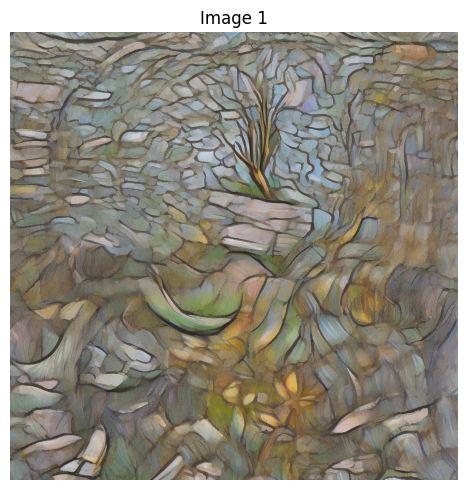

CPU times: user 30.2 s, sys: 32.9 s, total: 1min 3s
Wall time: 7min 53s


In [12]:
%%time
config = load_config()

run_inference(
    prompt="A beautiful landscape",
    height=768,
    width=768,
    num_images=1,
    num_inference_steps=100,
    output=True  
)

## DreamBooth Training

This Bash script uses PyTorch to detect the number of available GPUs, automatically selects either the multi-GPU or single-GPU configuration file, and then launches the DreamBooth training process on Stable Diffusion via `accelerate launch` with your specified parameters. It also captures the start and end timestamps to calculate the total training duration.

> **Tip:** To enable full, verbose logging, add the `--log_level=DEBUG` flag to your command.


In [13]:
%%time
# Use the project_root variable
project_root_str = str(project_root)
CONFIG_DIR = f"{project_root_str}/config"
OUTPUT_DIR = f"{project_root_str}/output"
DATA_DIR = f"{project_root_str}/data"

print(f"Project root: {project_root_str}")
print(f"Config dir: {CONFIG_DIR}")
print(f"Output dir: {OUTPUT_DIR}")
print(f"Data dir: {DATA_DIR}")

# Ensure directories exist
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(DATA_DIR, exist_ok=True)

# Detect GPUs and select config file
NUM_GPUS = torch.cuda.device_count()

if NUM_GPUS >= 2:
    CONFIG_FILE = f"{CONFIG_DIR}/default_config_multi-gpu.yaml"
    print(f"Detected {NUM_GPUS} GPUs, using {CONFIG_FILE}")
else:
    CONFIG_FILE = f"{CONFIG_DIR}/default_config_one-gpu.yaml"
    print(f"Detected {NUM_GPUS} GPU, using {CONFIG_FILE}")

# Verify config file exists
if not os.path.exists(CONFIG_FILE):
    print(f"Config file not found at: {CONFIG_FILE}")
    print(f"Contents of config directory:")
    if os.path.exists(CONFIG_DIR):
        for item in os.listdir(CONFIG_DIR):
            print(f"  - {item}")
    else:
        print(f"Config directory does not exist: {CONFIG_DIR}")
    raise FileNotFoundError(f"Error: Config file {CONFIG_FILE} not found!")

# Build the accelerate command
cmd = [
    "accelerate", "launch", "--config_file", CONFIG_FILE,
    "../core/train/train_dreambooth_aistudio.py",
    "--pretrained_model_name_or_path=stabilityai/stable-diffusion-2-1",
    "--log_level=ERROR",
    f"--instance_data_dir={DATA_DIR}/img",
    f"--output_dir={OUTPUT_DIR}/dreambooth/",
    "--instance_prompt=A modern laptop on a sandy beach with the ocean in the background, sunlight reflecting off the screen",
    "--resolution=512",
    "--train_batch_size=1",
    "--gradient_accumulation_steps=1",
    "--learning_rate=5e-6",
    "--lr_scheduler=constant",
    "--lr_warmup_steps=0",
    "--max_train_steps=300",
    "--logging_dir=/phoenix/tensorboard/tensorlogs",
    "--report_to=tensorboard",
    "--validation_prompt=A photo of an HP laptop on the sand with a sunset over the ocean in the background.",
    "--num_validation_images=1",
    "--validation_steps=100"
]

# Run the training
print("Starting DreamBooth training...")
print(f"Command: {' '.join(cmd)}")

import subprocess
import time

start_time = time.time()
try:
    result = subprocess.run(cmd, check=True, capture_output=True, text=True)
    print(result.stdout)
except subprocess.CalledProcessError as e:
    print(f"Training failed with return code {e.returncode}")
    print("STDOUT:", e.stdout)
    print("STDERR:", e.stderr)
    raise

end_time = time.time()
duration = int(end_time - start_time)
print(f"Training completed in {duration} seconds")

Project root: /home/jovyan/AI-Blueprints/generative-ai/image-generation-with-stablediffusion
Config dir: /home/jovyan/AI-Blueprints/generative-ai/image-generation-with-stablediffusion/config
Output dir: /home/jovyan/AI-Blueprints/generative-ai/image-generation-with-stablediffusion/output
Data dir: /home/jovyan/AI-Blueprints/generative-ai/image-generation-with-stablediffusion/data
Detected 2 GPUs, using /home/jovyan/AI-Blueprints/generative-ai/image-generation-with-stablediffusion/config/default_config_multi-gpu.yaml
Starting DreamBooth training...
Command: accelerate launch --config_file /home/jovyan/AI-Blueprints/generative-ai/image-generation-with-stablediffusion/config/default_config_multi-gpu.yaml ../core/train/train_dreambooth_aistudio.py --pretrained_model_name_or_path=stabilityai/stable-diffusion-2-1 --log_level=ERROR --instance_data_dir=/home/jovyan/AI-Blueprints/generative-ai/image-generation-with-stablediffusion/data/img --output_dir=/home/jovyan/AI-Blueprints/generative-ai/i

## Inference Local Model

This code imports functions from the inference_dreambooth module, loads a configuration, and then runs inference to generate images. It uses a prompt to create three images with a resolution of 768x768 pixels, executing 100 inference steps per image.

Detected 2 GPU(s); loading /home/jovyan/AI-Blueprints/generative-ai/image-generation-with-stablediffusion/config/default_config_multi-gpu.yaml
Loading DreamBooth model from: /home/jovyan/AI-Blueprints/generative-ai/image-generation-with-stablediffusion/output/dreambooth
Detected 2 GPU(s); loading /home/jovyan/AI-Blueprints/generative-ai/image-generation-with-stablediffusion/config/default_config_multi-gpu.yaml
GPU 0: reserving 45GB of VRAM.
GPU 1: reserving 45GB of VRAM.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Enabled attention slicing for memory efficiency


  0%|          | 0/3 [00:00<?, ?it/s]

[1/3]   2.17 s - Saved to /home/jovyan/AI-Blueprints/generative-ai/image-generation-with-stablediffusion/output/dreambooth_result_0.png


  0%|          | 0/3 [00:00<?, ?it/s]

[2/3]   1.27 s - Saved to /home/jovyan/AI-Blueprints/generative-ai/image-generation-with-stablediffusion/output/dreambooth_result_1.png


  0%|          | 0/3 [00:00<?, ?it/s]

[3/3]   1.28 s - Saved to /home/jovyan/AI-Blueprints/generative-ai/image-generation-with-stablediffusion/output/dreambooth_result_2.png

Avg 1.57s | Med 1.28s | Min 1.27s | Max 2.17s


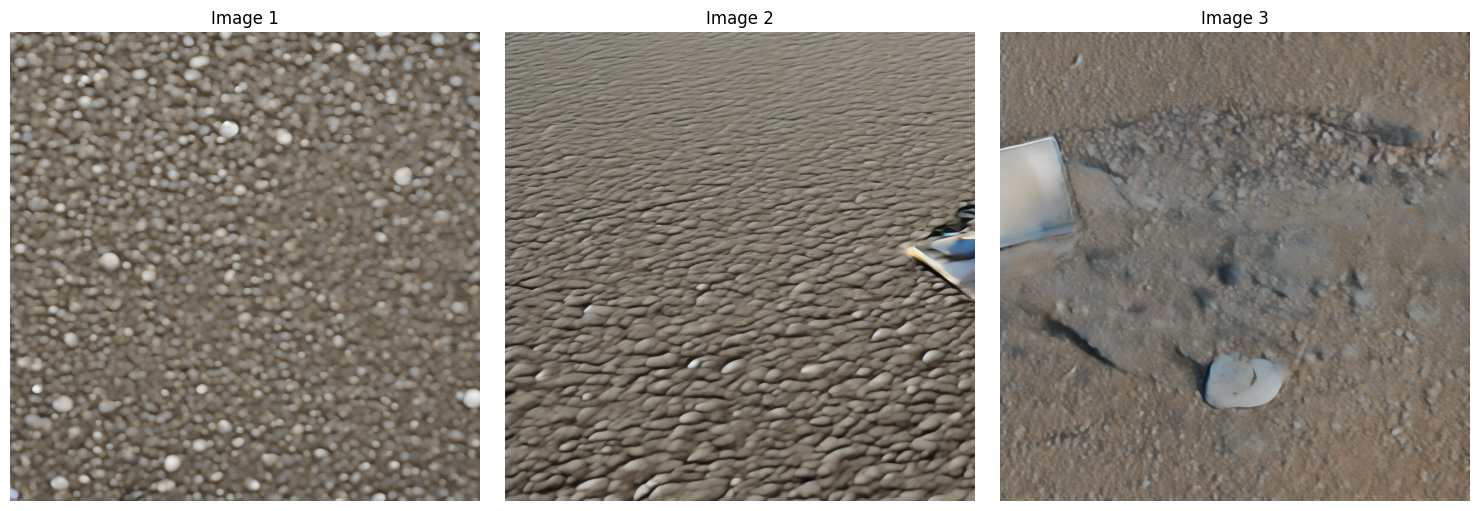

CPU times: user 35.7 s, sys: 29.6 s, total: 1min 5s
Wall time: 5min 53s


In [14]:
%%time
config = load_config_dreambooth()

# Setup and validate the DreamBooth model
dreambooth_model_path = setup_dreambooth_model()

run_inference_dreambooth(
    prompt="A high-quality photo of an HP laptop placed on the sand at the beach, with a sunset over the ocean in the background.", 
    height=768, 
    width=768, 
    num_images=3, 
    num_inference_steps=100,
    output=True,
    model_path=dreambooth_model_path
)

## Custom Image Quality Metrics
This section demonstrates how to evaluate generated images using custom metrics such as entropy and complexity. These metrics provide insights into the quality and characteristics of the generated images.

In [ ]:
# Setup for custom image quality evaluation
# This section prepares the environment for evaluating generated images
# using custom metrics like entropy and complexity

print("Setting up custom image evaluation environment...")
print("Custom metrics available: entropy_scorer, complexity_scorer")

: 

In [16]:
def get_latest_generated_image(directory: str = None, prefix: str = "dreambooth_result_", ext: str = ".png") -> str:
    """
    Returns the path of the most recent image that matches the specified pattern.
    Uses the project's output directory by default.
    """
    if directory is None:
        directory = str(get_output_dir())
    
    files = glob.glob(os.path.join(directory, f"{prefix}*{ext}"))
    if not files:
        raise FileNotFoundError(f"No generated images found in {directory}.")
    latest_file = max(files, key=os.path.getmtime)
    return latest_file

Detected 2 GPU(s); loading /home/jovyan/AI-Blueprints/generative-ai/image-generation-with-stablediffusion/config/default_config_multi-gpu.yaml
Loading DreamBooth model from: /home/jovyan/AI-Blueprints/generative-ai/image-generation-with-stablediffusion/output/dreambooth
Detected 2 GPU(s); loading /home/jovyan/AI-Blueprints/generative-ai/image-generation-with-stablediffusion/config/default_config_multi-gpu.yaml
GPU 0: reserving 45GB of VRAM.
GPU 1: reserving 45GB of VRAM.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Enabled attention slicing for memory efficiency


  0%|          | 0/3 [00:00<?, ?it/s]

[1/1]   1.73 s - Saved to /home/jovyan/AI-Blueprints/generative-ai/image-generation-with-stablediffusion/output/dreambooth_result_0.png

Avg 1.73s | Med 1.73s | Min 1.73s | Max 1.73s


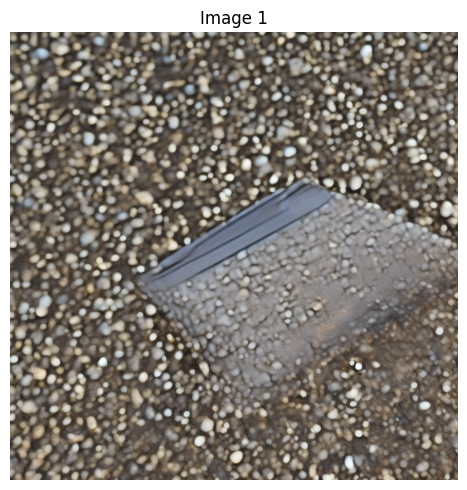

[set_custom_image_path] CUSTOM_IMAGE_PATH: /home/jovyan/AI-Blueprints/generative-ai/image-generation-with-stablediffusion/output/dreambooth_result_0.png
CPU times: user 33.8 s, sys: 27.7 s, total: 1min 1s
Wall time: 5min 41s


In [ ]:
%%time
config = load_config_dreambooth()

prompt_text = ("A high-quality photo of an HP laptop placed on the sand at the beach, "
               "with a sunset over the ocean in the background.")

# Setup and validate the DreamBooth model
dreambooth_model_path = setup_dreambooth_model()

# Generate a single image for evaluation
run_inference_dreambooth(
    prompt=prompt_text, 
    height=768, 
    width=768, 
    num_images=1, 
    num_inference_steps=100,
    output=True,
    model_path=dreambooth_model_path
)

# Evaluate the generated image with custom metrics
generated_image_path = get_latest_generated_image()
set_custom_image_path(generated_image_path)

# Calculate custom image quality metrics
print(f"Evaluating image: {generated_image_path}")
print("Available custom metrics:")
print("- Entropy Scorer: Measures information content and randomness in the image")
print("- Complexity Scorer: Measures structural complexity based on frequency domain analysis")

# Note: To use these metrics in a comprehensive evaluation pipeline,
# you would integrate them with your preferred evaluation framework

## Model Service

Using MLflow, we will save and load the model in an integrated manner, enabling the traceability and reproducibility of experiments. MLflow will facilitate model versioning, monitoring, and deployment, ensuring a robust pipeline for your project.

In [18]:
%%time
deploy_model()

2025-07-05 23:46:55,090 — INFO — Using accelerate cfg: /home/jovyan/AI-Blueprints/generative-ai/image-generation-with-stablediffusion/config/default_config_multi-gpu.yaml
2025-07-05 23:46:55,439 — INFO — Starting model deployment...
2025/07/05 23:46:55 INFO mlflow.tracking.fluent: Experiment with name 'ImageGeneration' does not exist. Creating a new experiment.
2025-07-05 23:46:55,660 — INFO — Using local base model: /home/jovyan/AI-Blueprints/generative-ai/image-generation-with-stablediffusion/models/stable-diffusion-2-1
2025-07-05 23:46:55,665 — INFO — Using finetuned model: /home/jovyan/AI-Blueprints/generative-ai/image-generation-with-stablediffusion/output/dreambooth
2025-07-05 23:46:55,666 — INFO — Using base model: /home/jovyan/AI-Blueprints/generative-ai/image-generation-with-stablediffusion/models/stable-diffusion-2-1
2025-07-05 23:46:57,179 — INFO — 📦 Logging artifacts and model...
2025/07/05 23:46:57 INFO mlflow.models.signature: Inferring model signature from type hints
/op

2025-07-06 00:04:29,621 — INFO — ✅ Model logged to MLflow at 'image_generation_model'
Successfully registered model 'ImageGenerationService'.
Created version '1' of model 'ImageGenerationService'.
2025-07-06 00:04:30,455 — INFO — 🏷️ Registered 'ImageGenerationService' (run df4789a5f30144b2833a77a1d38d2519)
2025-07-06 00:04:30,456 — INFO — Model deployment completed successfully


CPU times: user 4.15 s, sys: 2min 28s, total: 2min 32s
Wall time: 17min 41s


In [19]:
logger.info('Notebook execution completed.')

2025-07-06 00:04:30 - INFO - Notebook execution completed.


Built with ❤️ using Z by HP AI Studio